In [2]:
from sklearn.cluster import KMeans
from ast import literal_eval
from matplotlib.colors import ListedColormap, BoundaryNorm, Normalize
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import umap.umap_ as umap
import matplotlib

matplotlib.rc('font', family='Heiti TC')

In [3]:
# read data from csv
df = pd.read_csv('test.csv')

In [4]:
print(df.head(5))
print(df.tail(5))


   Unnamed: 0     name                     place_id                user_id  \
0           0  麒麟創作拉麵坊  ChIJRYLOKvmpQjQRSrAwjEP7e9I  110466093739231104001   
1           1  麒麟創作拉麵坊  ChIJRYLOKvmpQjQRSrAwjEP7e9I  100960361950426267904   
2           2  麒麟創作拉麵坊  ChIJRYLOKvmpQjQRSrAwjEP7e9I  105129428418363205426   
3           3  麒麟創作拉麵坊  ChIJRYLOKvmpQjQRSrAwjEP7e9I  107890985019526067340   
4           4  麒麟創作拉麵坊  ChIJRYLOKvmpQjQRSrAwjEP7e9I  103620193904175325358   

   rating                                           combined  n_tokens  \
0       5  Score: ★★★★★; Content: 聽說晚上場需要排隊領完號碼牌要等兩個小時才能領...       621   
1       4  Score: ★★★★; Content: 也是耳聞已久前來朝聖 進來環境跟以往拉麵店風格不...       458   
2       4  Score: ★★★★; Content: 開幕即巔峰的拉麵，特別起了一大早排第二個，點了特...       616   
3       4  Score: ★★★★; Content: 白松露🐔魚貝拉麵湯頭很鮮 但是蛤蜊有沙 麵條正常...       125   
4       5  Score: ★★★★★; Content: 今日和朋友去吃的餐點，平日去晚上17:30點餐...       590   

                                          embeddings  
0  [-0.020609794184565544, -0.0

In [5]:
print(df.shape)
df.drop_duplicates(subset=['place_id','user_id'],inplace=True)
print(df.shape)

(70320, 8)
(68828, 8)


In [6]:
# convert embeddings to np.array metrix
df["embeddings"] = df.embeddings.apply(literal_eval).apply(np.array)
matrix = np.vstack(df.embeddings.values)

# clustering
n_clusters = 10

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=3)
kmeans.fit(matrix)
labels = kmeans.labels_
df["Cluster"] = labels

In [67]:
print(df.sort_values('n_tokens').head(20))
print(df[df.n_tokens>30].sort_values('n_tokens'))


       Unnamed: 0                      name                     place_id  \
46887          98                      初代拉麵  ChIJR5hupYUXbjQRGz8lX9ven-0   
47497         708         極道ラーメン-極道拉麵雞白湯專門店  ChIJR0Its_AFbjQRQvbS9Jnmioo   
41907         503  Due Italian黃金鹽拉麵(台中三井分店)  ChIJbVWzkW9raTQROd92FUTUjd8   
811           859                  豚人拉麵 新店店  ChIJIYYAx74BaDQR3NdYXf5FeVU   
41909         505  Due Italian黃金鹽拉麵(台中三井分店)  ChIJbVWzkW9raTQROd92FUTUjd8   
2239         2334                豚人拉麵 板橋真龍店  ChIJC2wCBgCpQjQR4r0nU1g668k   
31339         536                      蘭亭食堂  ChIJ-zl8zPIfaDQRNhAr5cD_MEw   
2042         2118                  麵屋武藏 光復店  ChIJrTD86ZurQjQRltD43-NNGZA   
31333         529                      蘭亭食堂  ChIJ-zl8zPIfaDQRNhAr5cD_MEw   
59817        2610                 一風堂台北101店  ChIJhRW-Fq2rQjQRUQF1esdNiN4   
53233        1226                      龍吟拉麵  ChIJ1Xmh533mZzQR_njN1y25pp4   
68869        1020                 京正拉麵(育樂店)  ChIJp32mpI12bjQRgBzS3gBa46g   
68880       

In [7]:
# create UMAP reducer
reducer = umap.UMAP(n_neighbors=200,min_dist=0.1, n_components=2, metric='cosine')
data_umap = reducer.fit_transform(matrix)

In [30]:

df['umap_1'] = data_umap[:, 0]
df['umap_2'] = data_umap[:, 1]
colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))
cmap = ListedColormap(colors)
norm = BoundaryNorm(np.arange(-0.5, n_clusters + 0.5, 1), cmap.N)


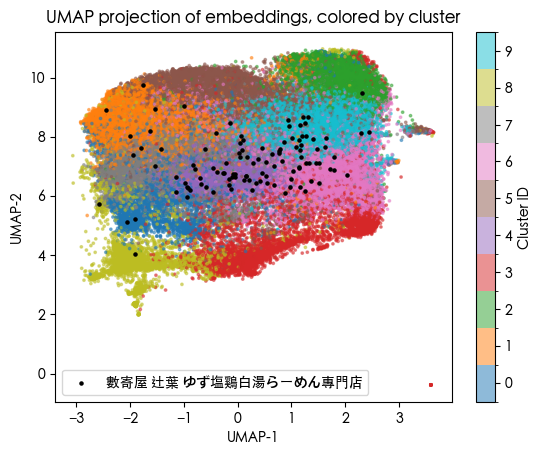

In [31]:
mask = (df['name'] == "數寄屋 辻葉 ゆず塩鷄白湯らーめん專門店")

scatter = plt.scatter('umap_1', 'umap_2', s=3, c=labels, cmap=cmap, data=df,
                        norm=norm, alpha=0.5,label='')
plt.scatter(data_umap[mask, 0], data_umap[mask, 1], s=5, color='black',
                        alpha=1, label='數寄屋 辻葉 ゆず塩鷄白湯らーめん專門店')
plt.colorbar(scatter, ticks=np.arange(n_clusters), label='Cluster ID')  # Adjust colorbar to show discrete values
plt.title('UMAP projection of embeddings, colored by cluster')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.legend()

In [42]:
# show clusters distribution of a ramen 數寄屋 辻葉 ゆず塩鷄白湯らーめん專門店
print(df[mask].groupby('Cluster').size().sort_values(ascending=False)
        .reset_index(name='Count')
        .assign(Percentage=lambda x: (x['Count'] / x['Count'].sum()) * 100)
        .assign(Accumulated=lambda x: (x['Percentage'].cumsum()) ))

# consider cluster 4,9,6 as features of 數寄屋 

   Cluster  Count  Percentage  Accumulated
0        4     43   39.090909    39.090909
1        9     27   24.545455    63.636364
2        6     16   14.545455    78.181818
3        0      9    8.181818    86.363636
4        1      7    6.363636    92.727273
5        7      4    3.636364    96.363636
6        8      2    1.818182    98.181818
7        2      1    0.909091    99.090909
8        5      1    0.909091   100.000000


In [44]:
mask = (df['name'] == "海貓亭拉麵 うみねこ亭")
print(df[mask].groupby('Cluster').size().sort_values(ascending=False)
        .reset_index(name='Count')
        .assign(Percentage=lambda x: (x['Count'] / x['Count'].sum()) * 100)
        .assign(Accumulated=lambda x: (x['Percentage'].cumsum()) ))

## consider cluster 9,4,6,7 as features of 海貓亭 

   Cluster  Count  Percentage  Accumulated
0        9     30   27.272727    27.272727
1        4     28   25.454545    52.727273
2        6     23   20.909091    73.636364
3        7     12   10.909091    84.545455
4        5      7    6.363636    90.909091
5        1      4    3.636364    94.545455
6        3      2    1.818182    96.363636
7        8      2    1.818182    98.181818
8        0      1    0.909091    99.090909
9        2      1    0.909091   100.000000


/var/folders/3k/syzcms_55r97fjwz1s3h8kkm0000gn/T/ipykernel_70007/1970221591.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(df['n_tokens'], fill=True, common_norm=False, palette="crest",


Text(0, 0.5, 'Probability Density')

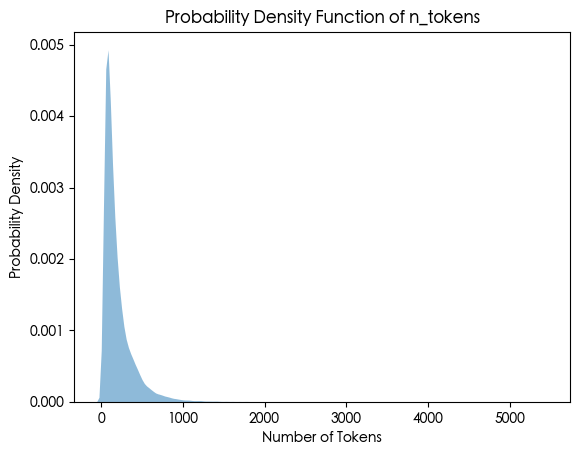

In [10]:
sns.kdeplot(df['n_tokens'], fill=True, common_norm=False, palette="crest",
            alpha=.5, linewidth=0)
plt.title('Probability Density Function of n_tokens')
plt.xlabel('Number of Tokens')
plt.ylabel('Probability Density')

Text(0, 0.5, 'Density')

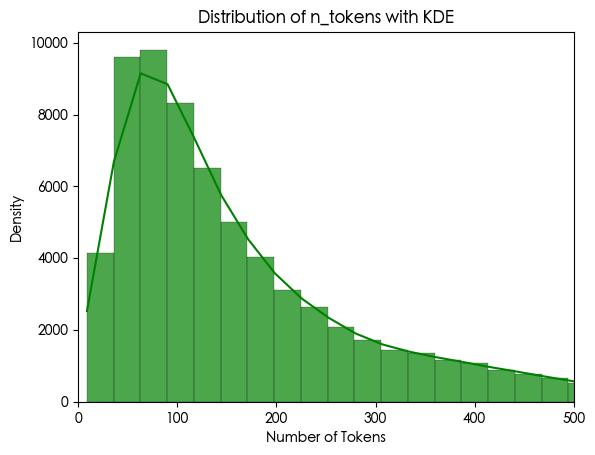

In [81]:
sns.histplot(df['n_tokens'], kde=True, color='green', bins=200, alpha=0.7)
plt.xlim(0,500)
plt.title('Distribution of n_tokens with KDE')
plt.xlabel('Number of Tokens')
plt.ylabel('Density')

n_tokens less than 40:  5434


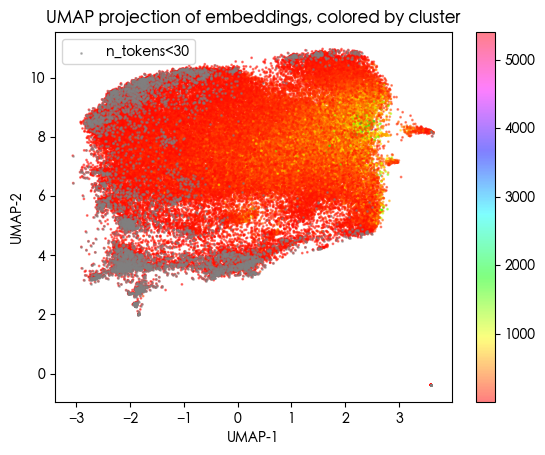

In [83]:
norm = Normalize(vmin=df['n_tokens'].min(), vmax=df['n_tokens'].max())

scatter2 = plt.scatter('umap_1', 'umap_2', s=1, c='n_tokens', cmap='hsv', data=df,
                        alpha=0.5,label='')
plt.colorbar(scatter2)
plt.title('UMAP projection of embeddings, colored by cluster')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')

mask = df['n_tokens'] < 40
plt.scatter(data_umap[mask, 0], data_umap[mask, 1], s=1, color='gray',
                        alpha=0.5, label='n_tokens<30')
plt.legend()
print("n_tokens less than 40: ", mask[mask==True].shape[0])

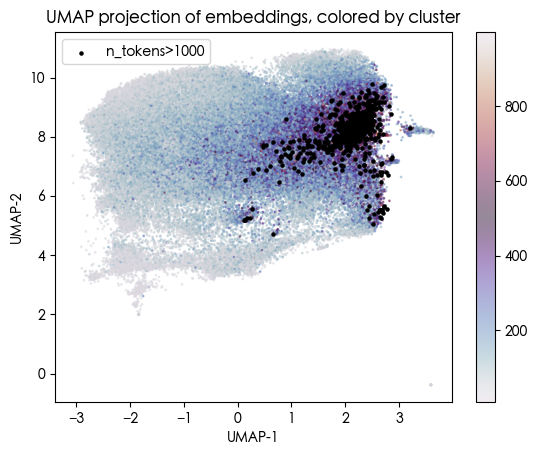

In [46]:
mask_1000 = df['n_tokens'] < 1000

scatter2 = plt.scatter(data_umap[mask_1000, 0], data_umap[mask_1000, 1], s=1,
                        c=df[mask_1000]['n_tokens'], cmap='twilight', alpha=0.5,label='')
plt.colorbar(scatter2)
plt.title('UMAP projection of embeddings, colored by cluster')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')

mask = (df['n_tokens'] > 1000) & (df['n_tokens'] < 4000)
plt.scatter(data_umap[mask, 0], data_umap[mask, 1], s=5, color='black',
                        alpha=1, label='n_tokens>1000')
plt.legend()

In [47]:
## length of token might have significant impact to clustering
print(df[mask].groupby('Cluster').size().sort_values(ascending=False)
        .reset_index(name='Count')
        .assign(Percentage=lambda x: (x['Count'] / x['Count'].sum()) * 100)
        .assign(Accumulated=lambda x: (x['Percentage'].cumsum()) ))


   Cluster  Count  Percentage  Accumulated
0        9    470   75.806452    75.806452
1        6     67   10.806452    86.612903
2        2     32    5.161290    91.774194
3        4     30    4.838710    96.612903
4        3     11    1.774194    98.387097
5        7     10    1.612903   100.000000


Text(0, 0.5, 'Density')

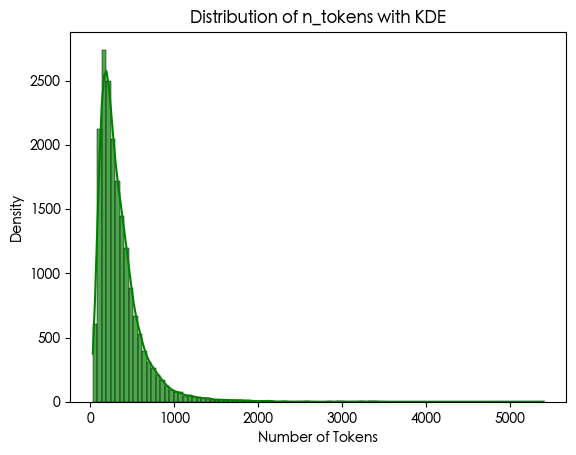

In [51]:
sns.histplot(df[df.Cluster.isin([9,6])]['n_tokens'], kde=True, color='green', bins=100, alpha=0.7)
plt.title('Distribution of n_tokens with KDE')
plt.xlabel('Number of Tokens')
plt.ylabel('Density')

In [98]:
print(df[df['n_tokens'] < 40].shape[0])
print(df[df['n_tokens'] > 800].shape[0])

5434
1265


Text(0, 0.5, 'Density')

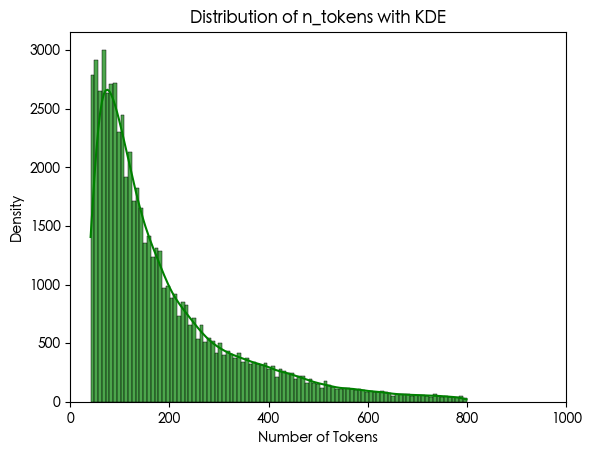

In [100]:
## redo with n_tokens between 40 and 800
df2 = df.copy()
df2 = df2[(df['n_tokens'] > 40) & (df['n_tokens'] < 800)]

sns.histplot(df2['n_tokens'], kde=True, color='green', bins=100, alpha=0.7)
plt.xlim(0,1000)
plt.title('Distribution of n_tokens with KDE')
plt.xlabel('Number of Tokens')
plt.ylabel('Density')


In [101]:
# clustering
matrix2 = np.vstack(df2.embeddings.values)
n_clusters = 10

kmeans2 = KMeans(n_clusters=n_clusters, init="k-means++", random_state=5)
kmeans2.fit(matrix2)
labels2 = kmeans2.labels_
df2["Cluster"] = labels2

In [102]:
# create UMAP reducer
reducer2 = umap.UMAP(n_neighbors=100,min_dist=0.1, n_components=2, metric='cosine')
data_umap2 = reducer2.fit_transform(matrix2)
df2['umap_1'] = data_umap2[:, 0]
df2['umap_2'] = data_umap2[:, 1]

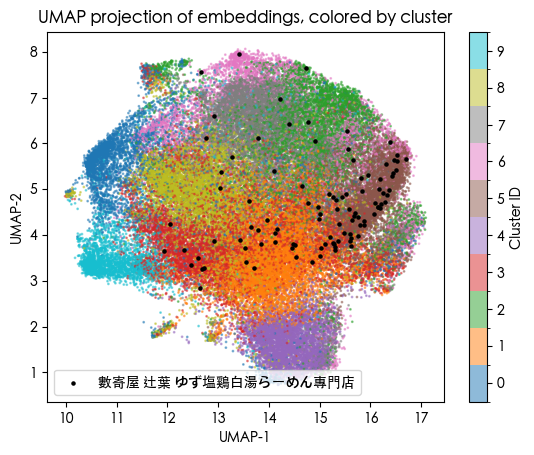

In [104]:
colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))
cmap = ListedColormap(colors)
norm = BoundaryNorm(np.arange(-0.5, n_clusters + 0.5, 1), cmap.N)

mask = df2['name'] == "數寄屋 辻葉 ゆず塩鷄白湯らーめん專門店"

scatter = plt.scatter('umap_1', 'umap_2', s=1, c=labels2, cmap=cmap, data=df2,
                        norm=norm, alpha=0.5,label='')
plt.scatter(data_umap2[mask, 0], data_umap2[mask, 1], s=5, color='black',
                        alpha=1, label='數寄屋 辻葉 ゆず塩鷄白湯らーめん專門店')
plt.colorbar(scatter, ticks=np.arange(n_clusters), label='Cluster ID')  # Adjust colorbar to show discrete values
plt.title('UMAP projection of embeddings, colored by cluster')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.legend()

Text(0, 0.5, 'UMAP-2')

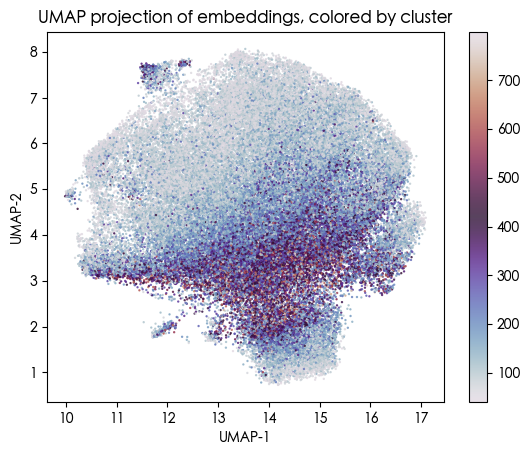

In [109]:
norm = Normalize(vmin=df2['n_tokens'].min(), vmax=df2['n_tokens'].max())

scatter2 = plt.scatter('umap_1', 'umap_2', s=0.5, c='n_tokens', cmap='twilight', data=df2,
                        alpha=0.8,label='')
plt.colorbar(scatter2)
plt.title('UMAP projection of embeddings, colored by cluster')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
